# Module 5. Labs two-sample t-test

In [1]:
# Package imports
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests
from pandas.api.types import CategoricalDtype
import pandas as pd                                 # Dataframe
import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

## Android Persistence libraries performance comparison

We analyzed the results of performance measurements for Android persistence libraries (Akin, 2016). Experiments were performed for different combinations of *DataSize* (Small, Medium, Large) and *PersistenceType* (GreenDAO, Realm, SharedPreferences, SQLite). For each data size, we were able to determine which persistence type yielded the best results.

Now we will verify if the best persistence type at first glance is also *significantly* better than the competition.

Specifically: Using a two-sample test for each data size, verify that the mean of the best persistence type is significantly lower than the mean of the second best and the worst scoring type.

Can we maintain the conclusion that for a given data size, one persistence type is best, i.e. is significantly better than any other persistence type?

In [2]:
android = pd.read_csv('../data/android_persistence_cpu.csv',delimiter=";") # of sep=';
print(android.head())
android.PersistenceType = android.PersistenceType.astype('category')
android.DataSize = android.DataSize.astype(CategoricalDtype(categories=['Small', 'Medium', 'Large'], ordered=True))

   Time    PersistenceType DataSize
0  1.81  Sharedpreferences    Small
1  1.35  Sharedpreferences    Small
2  1.84  Sharedpreferences    Small
3  1.54  Sharedpreferences    Small
4  1.81  Sharedpreferences    Small


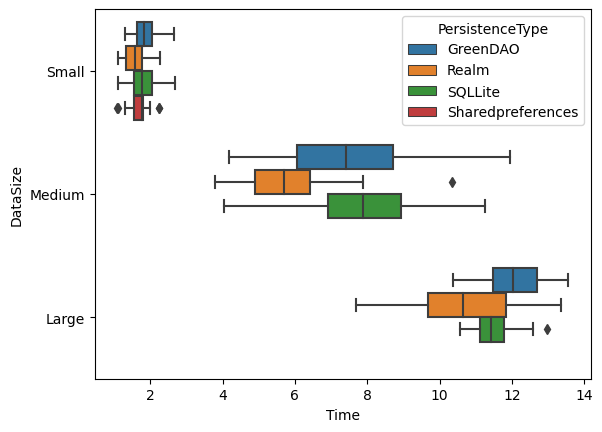

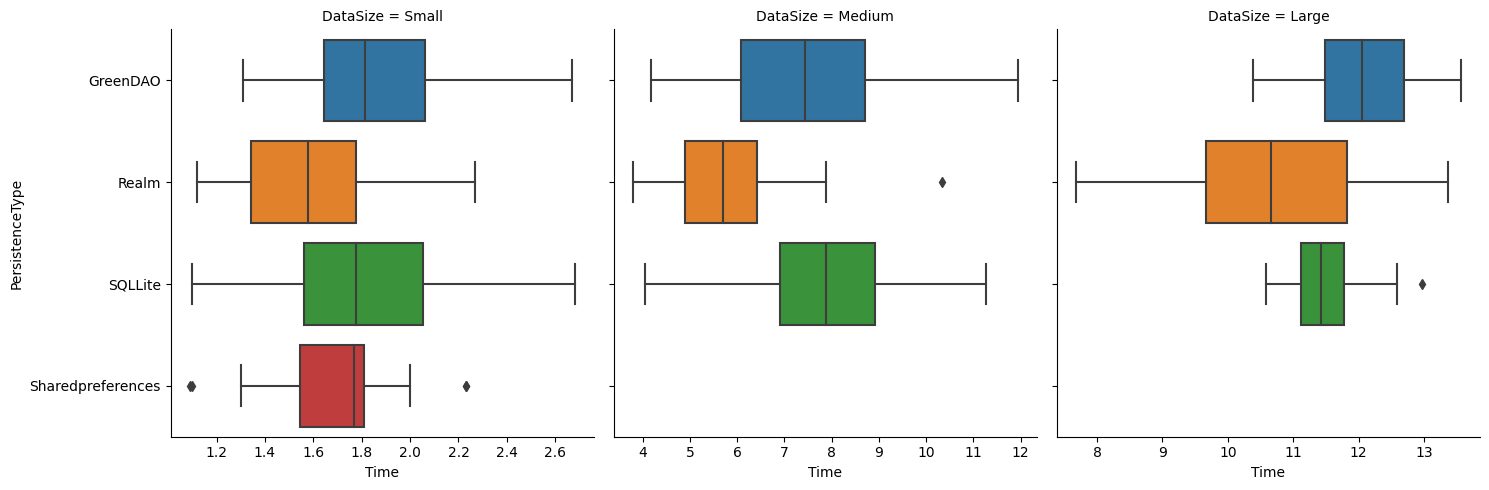

In [7]:
sns.boxplot(data=android, x="Time",y="DataSize",hue="PersistenceType")
sns.catplot(data=android, kind="box",col="DataSize",x="Time",y="PersistenceType",sharex=False) # shareX zorgt dat elke categorie eigen x-as heeft

In [18]:
android.groupby(["DataSize", "PersistenceType"]).Time.mean()

DataSize  PersistenceType  
Small     GreenDAO              1.893667
          Realm                 1.599000
          SQLLite               1.799000
          Sharedpreferences     1.673667
Medium    GreenDAO              7.454000
          Realm                 5.818000
          SQLLite               7.794000
          Sharedpreferences          NaN
Large     GreenDAO             12.110333
          Realm                10.651667
          SQLLite              11.515000
          Sharedpreferences          NaN
Name: Time, dtype: float64

In [16]:
# We gaan per Datasize kijken welke van persistenceType het beste is (snelste tijd)
#H0 tijd is zelfde
#H1 tijdBeste - tijd2de < 0
android.groupby(["DataSize", "PersistenceType"]).Time.mean()
#Small hier zijn Realm en SharedPreferences de laagste dus die vergelijken
smallRealm = android[(android.DataSize == "Small") & (android.PersistenceType == "Realm")].Time

smallShared = android[(android.DataSize == "Small") & (android.PersistenceType == "Sharedpreferences")].Time

stats.ttest_ind(a=smallRealm, b=smallShared, alternative='less', equal_var=False) 
#p-waarde is groot dus H0 aannemen , want 0.16 > 0.05 (significantieniveau), er is dus geen significant verschil
# Op examen krijg je significantieniveau

Ttest_indResult(statistic=-0.9624716662718156, pvalue=0.16992370571901444)

In [19]:
#Voor medium
smallRealm = android[(android.DataSize == "Medium") & (android.PersistenceType == "Realm")].Time
smallShared = android[(android.DataSize == "Medium") & (android.PersistenceType == "GreenDAO")].Time
stats.ttest_ind(a=smallRealm, b=smallShared, alternative='less', equal_var=False) 

#p-waarde < 0.05 dus nullhypothese verwerpen, er is een significant verschil

Ttest_indResult(statistic=-3.720451024030081, pvalue=0.00025063005682348326)

In [20]:
largeRealm = android[(android.DataSize == "Large") & (android.PersistenceType == "Realm")].Time
largeSQL = android[(android.DataSize == "Large") & (android.PersistenceType == "SQLLite")].Time
stats.ttest_ind(a=largeRealm, b=largeSQL, alternative='less', equal_var=False) 
# p-waarde < 0.05 dus h0 verwerpen, er is een significant verschil

Ttest_indResult(statistic=-3.1251713022860717, pvalue=0.0016999220614984435)

### Answers

The table below provides an overview of the best and second best persistence type for each data size (based on the sample mean).

| Data Size | Best  | 2nd Best          | p-value   |
| :-------- | :---- | :---------------- | :-------- |
| Small     | Realm | SharedPreferences | 0.1699    |
| Medium    | Realm | GreenDAO          | 0.0002506 |
| Large     | Realm | SQLite            | 0.0017    |

The conclusion of Akin (2016), which states that Realm is the most efficient persistence type, still holds, but for the small data sets the difference is not significant.

Note that we have not explicitly selected a specific significance level in advance. However, for $\alpha$ = 0.1, 0.05 or even 0.01, the same conclusion can be drawn.

##  Comparing test results between groups

A large number of students participated in a test that was organized in several successive sessions. Because creating a separate test for each session was practically unfeasible, the same questions were used in each session. Consequently, there is a danger that students could pass on information about the test to the groups that still had to come after. Later groups then have an advantage over the first. However, this also evident from the test scores?

The file `test-results.csv` contains all results of the test. The score is a floating point number with maximum 40. If the score field is empty, this indicates a student that was absent. Each session is identified by a letter, in the order of the consecutive sessions.

- Day 1: sessions A, B
- Day 2: sessions C, D, E
- Day 3: sessions F, G, H

Sessions A and B were conducted on a different campus, so it could be assumed that there is little to no communication with students from other sessions.

If information was passed on successfully, we expect the scores of later groups to be significantly better than the first.

**Note** that the reverse reasoning does not necessarily hold: if it turns out that the result of later sessions is indeed significantly better, this does not necessarily mean that the (only) cause is passing on of information. There may also be other causes (e.g. “weaker” class groups happen to be scheduled earlier).

1. Explore the data. Calculate the appropriate measures for central tendency and dispersion for the full dataset and for each session individually.
2. Plot a bar graph of the average score per session with error bars denoting one standard deviation.
3. Make a box plot of the scores divided per group. Compare the sessions listed below. Do you think there is a significant difference between the results? Can we suspect that information has been passed on?
    - A and B
    - C, D and E
    - F, G and H
    - C and H
    - A and H
4. Use an appropriate statistical test to determine whether the differences between the groups listed above are also *significant*. Can we conclude that the later groups score better or not?

In [21]:
groups = pd.read_csv("../data/test-results.csv")
groups.head()

,Session,Score
0,A,12.5
1,A,7.5
2,A,NaN
3,A,21.0
4,A,10.0


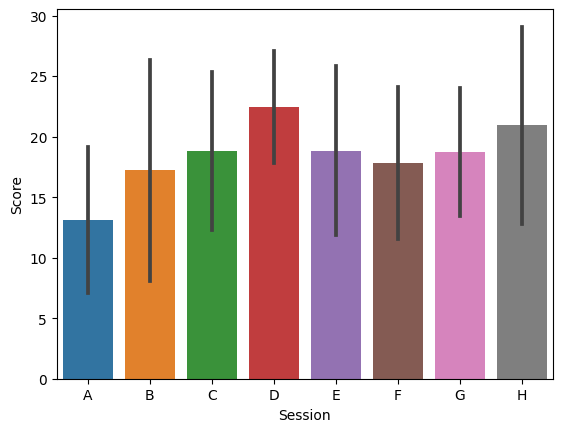

In [23]:
sns.barplot(data=groups, x='Session', y='Score',estimator="mean", errorbar='sd'); 
#estimator moet er eigenlijk niet bij

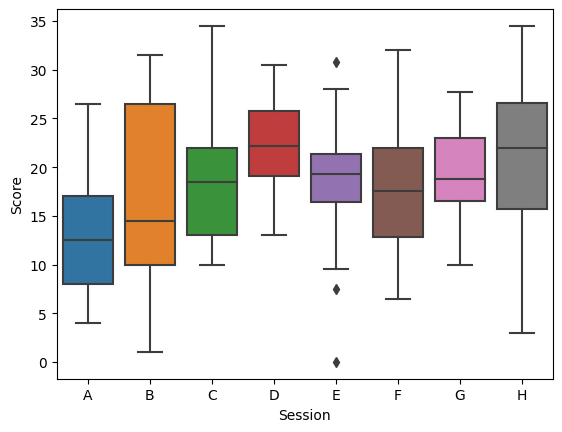

In [24]:
sns.boxplot(data=groups, x='Session', y='Score');

In [28]:
# A en B
# H0: A-B = 0 (A en B gelijk)
# H1: A - B < 0 (dus A lagere score dan B)
agroep = groups[(groups.Session == "A")].Score
bgroep = groups[(groups.Session == "B")].Score
stats.ttest_ind(a=agroep, b=bgroep, alternative='less', equal_var=False,nan_policy="omit")  
#nan_policy voor als er NAN in voorkomen, met omit laat je deze achterwegen
# P > 0.05, nullhypothese behouden, geen significant verschil

Ttest_indResult(statistic=-1.6541070146039145, pvalue=0.053557184014211265)

In [30]:
# C en D
# H0: C-D = 0 (C en D gelijk)
# H1: C - D < 0 (dus C lagere score dan D)
cgroep = groups[(groups.Session == "C")].Score
dgroep = groups[(groups.Session == "D")].Score
stats.ttest_ind(a=cgroep, b=dgroep, alternative='less', equal_var=False,nan_policy="omit")  
#nan_policy voor als er NAN in voorkomen, met omit laat je deze achterwegen
# P < 0.05, nullhypothese verwerpen, er is een significant verschil

Ttest_indResult(statistic=-2.291650017323013, pvalue=0.013433158948369566)

In [31]:
# E en D
# H0: E-D = 0 (C en D gelijk)
# H1: E - D < 0 (dus C lagere score dan D)
egroep = groups[(groups.Session == "E")].Score
dgroep = groups[(groups.Session == "D")].Score
stats.ttest_ind(a=egroep, b=dgroep, alternative='less', equal_var=False,nan_policy="omit")  
#nan_policy voor als er NAN in voorkomen, met omit laat je deze achterwegen
# P < 0.05, nullhypothese verwerpen, er is een significant verschil

Ttest_indResult(statistic=-2.056999632486277, pvalue=0.023558387239853682)

In [34]:
# F en H
# H0: F-H = 0 (C en H gelijk)
# H1: F - H < 0 (dus C lagere score dan H)
groep1 = groups[(groups.Session == "F")].Score
groep2 = groups[(groups.Session == "H")].Score
stats.ttest_ind(a=groep1, b=groep2, alternative='less', equal_var=False,nan_policy="omit")  
#nan_policy voor als er NAN in voorkomen, met omit laat je deze achterwegen
# P > 0.05, nullhypothese behouden, er is geen significant verschil

Ttest_indResult(statistic=-1.6021549425300858, pvalue=0.057673501327015604)

In [35]:
# G en H
# H0: G-H = 0 (G en H gelijk)
# H1: G - H < 0 (dus G lagere score dan H)
groep1 = groups[(groups.Session == "G")].Score
groep2 = groups[(groups.Session == "H")].Score
stats.ttest_ind(a=groep1, b=groep2, alternative='less', equal_var=False,nan_policy="omit")  
#nan_policy voor als er NAN in voorkomen, met omit laat je deze achterwegen
# P > 0.05, nullhypothese behouden, er is geen significant verschil

Ttest_indResult(statistic=-1.2135428543345408, pvalue=0.11555943437549136)

In [33]:
# C en H
# H0: C-H = 0 (C en H gelijk)
# H1: C - H < 0 (dus C lagere score dan H)
groep1 = groups[(groups.Session == "C")].Score
groep2 = groups[(groups.Session == "H")].Score
stats.ttest_ind(a=groep1, b=groep2, alternative='less', equal_var=False,nan_policy="omit")  
#nan_policy voor als er NAN in voorkomen, met omit laat je deze achterwegen
# P > 0.05, nullhypothese behouden, er is geen significant verschil

Ttest_indResult(statistic=-1.0634890645895432, pvalue=0.1463105697202284)

In [32]:
# A en H
# H0: A-H = 0 (A en H gelijk)
# H1: A - H < 0 (dus A lagere score dan H)
groep1 = groups[(groups.Session == "A")].Score
groep2 = groups[(groups.Session == "H")].Score
stats.ttest_ind(a=groep1, b=groep2, alternative='less', equal_var=False,nan_policy="omit")  
#nan_policy voor als er NAN in voorkomen, met omit laat je deze achterwegen
# P < 0.05, nullhypothese verwerpen, er is een significant verschil

Ttest_indResult(statistic=-3.68689849737299, pvalue=0.00032887095672805235)

### Answers

The average score in each session was:

| Session | Average score |
| :-----: | :------------ |
|    A    | 13.1          |
|    B    | 17.2          |
|    C    | 18.8          |
|    D    | 22.5          |
|    E    | 18.9          |
|    F    | 17.8          |
|    G    | 18.7          |
|    H    | 20.9          |

The table below shows the p-value of a one-sided t-test of two samples between the given sessions:

| Alt. hypothesis                       | p-value   |
| :------------------------------------ | :-------- |
| $\overline{x}_A - \overline{x}_B < 0$ | 0.05356   |
| $\overline{x}_C - \overline{x}_D < 0$ | 0.01343   |
| $\overline{x}_E - \overline{x}_D < 0$ | 0.02356   |
| $\overline{x}_F - \overline{x}_H < 0$ | 0.05767   |
| $\overline{x}_G - \overline{x}_H < 0$ | 0.1156    |
| $\overline{x}_C - \overline{x}_H < 0$ | 0.1463    |
| $\overline{x}_A - \overline{x}_H < 0$ | 0.0003289 |

Remarks:

- The difference between **session A and B**, although it seems quite large, is insignificant for $\alpha = 0.05$
- **Sessions C, D and E**:
  - Session D had the highest score. Sessions C and E had similar results, at least the average score was similar.
  - Session D has a significantly higher score than either sessions C and E. However, session E came _after_ D, so the cause is definitely not the passing of information.
- The differences between **sessions F, G and H** insignificant
- **Sessions C and H** are respectively the first and the last session on the same campus. So, if there is an opportunity to pass on information about the test, there's definitely enough time between these two sessions. However, the difference is not significant!
- The difference between **sessions A and H** are significant, but since they took place on different campuses, it is questionable that this difference is caused by passing on information.